### Module Import

In [1]:
# https://github.com/HideOnHouse/TorchBase

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from dataset import *
from model import get_Model
from learning import *
from inference import *

torch.__version__

'1.11.0+cu102'

### 함수 선언

In [2]:
def label2int(data, label_tags):
    for i in range(len(data)):
        data.iloc[i,1] = label_tags.index(data.iloc[i, 1])
    return data


def draw_history(history):
    train_loss = history["train_loss"]
    train_acc = history["train_acc"]
    valid_loss = history["valid_loss"]
    valid_acc = history["valid_acc"]

    plt.subplot(2,1,1)
    plt.title("Loss")
    plt.plot(train_loss, label="train")
    plt.plot(valid_loss, label="valid")
    plt.legend()

    plt.subplot(2,1,2)
    plt.title('Accuracy')
    plt.plot(train_acc, label="train")
    plt.plot(valid_acc, label="valid")
    plt.legend()

    plt.show()

In [3]:
# label_tags
label_tags = ['불안', '슬픔', '기쁨']

train_path = "train.csv"
test_path = "test.csv"

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

train_data = label2int(train_data, label_tags)
test_data = label2int(test_data, label_tags)

# your Data Pre-Processing
train_x, train_y = train_data.iloc[:, :1], train_data.iloc[:, 1:]
test_x, test_y = test_data.iloc[:, :1], test_data.iloc[:, 1:]

# data split
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, stratify=train_y, random_state=17, test_size=0.05)

# Check Train, Valid, Test Image's Shape
print("The Shape of Train Input: ", train_x.shape)
print("The Shape of Valid Input: ", valid_x.shape)
print("The Shape of Test Input: ", test_x.shape)

# Check Train, Valid Label's Shape
print("The Shape of Train Labels: ", train_y.shape)
print("The Shape of Valid Labels: ", valid_y.shape)
print("The Shape of Valid Labels: ", test_y.shape)

The Shape of Train Input:  (9405, 1)
The Shape of Valid Input:  (495, 1)
The Shape of Test Input:  (100, 1)
The Shape of Train Labels:  (9405, 1)
The Shape of Valid Labels:  (495, 1)
The Shape of Valid Labels:  (100, 1)


## Model 1
+ basis Model

### Klue BERT-base

In [4]:
model_path = "klue/bert-base"

train_dataset = MyDataset(train_x, train_y, model_path=model_path)
valid_dataset = MyDataset(valid_x, valid_y, model_path=model_path)
test_dataset = MyDataset(test_x, test_y, model_path=model_path)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [5]:
class_name = "MyModel_1"
model = get_Model(class_name, model_path)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

device

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


'cuda'

In [6]:
# train
print("============================= Train =============================")
history = train(model, device, optimizer, criterion, 10, train_loader, valid_loader)

============================= Train =============================
147it [01:30,  1.62it/s, epoch=1/10, loss=0.009362, acc=0.737]
16it [00:01,  8.31it/s, loss=0.015361, acc=0.794]

147it [01:31,  1.60it/s, epoch=2/10, loss=0.006649, acc=0.825]
16it [00:01,  8.22it/s, loss=0.014700, acc=0.796]

147it [01:31,  1.60it/s, epoch=3/10, loss=0.005058, acc=0.876]
16it [00:01,  8.49it/s, loss=0.016629, acc=0.788]

147it [01:31,  1.60it/s, epoch=4/10, loss=0.003368, acc=0.922]
16it [00:01,  8.48it/s, loss=0.017405, acc=0.804]

147it [01:31,  1.60it/s, epoch=5/10, loss=0.002129, acc=0.953]
16it [00:01,  8.48it/s, loss=0.022468, acc=0.802]

147it [01:31,  1.60it/s, epoch=6/10, loss=0.001412, acc=0.971]
16it [00:01,  8.54it/s, loss=0.025805, acc=0.800]

147it [01:31,  1.60it/s, epoch=7/10, loss=0.000931, acc=0.981]
16it [00:01,  8.55it/s, loss=0.028886, acc=0.786]

147it [01:31,  1.60it/s, epoch=8/10, loss=0.000732, acc=0.985]
16it [00:01,  8.32it/s, loss=0.028427, acc=0.790]

147it [01:31,  1.60it/

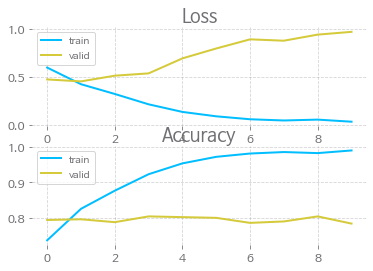

In [7]:
draw_history(history)

In [8]:
# Test
print("============================= Test =============================")
test_loss, test_acc = evaluate(model, device, criterion, test_loader)
print("test loss : {:.6f}".format(test_loss))
print("test acc : {:.3f}".format(test_acc))

============================= Test =============================
4it [00:00,  9.93it/s, loss=0.051182, acc=0.760]
test loss : 1.279549
test acc : 0.760


In [9]:
file_name = class_name+"_BERT"
torch.save(model, f"models/{file_name}.pt")
with open(f"models/{file_name}_history.pickle", 'wb') as f:
    pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)

### Klue RoBerta-base

In [4]:
model_path = "klue/roberta-base"

train_dataset = MyDataset(train_x, train_y, model_path=model_path)
valid_dataset = MyDataset(valid_x, valid_y, model_path=model_path)
test_dataset = MyDataset(test_x, test_y, model_path=model_path)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [5]:
class_name = "MyModel_1"
model = get_Model(class_name, model_path)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

device

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for

'cuda'

In [6]:
# train
print("============================= Train =============================")
history = train(model, device, optimizer, criterion, 10, train_loader, valid_loader)

============================= Train =============================
147it [01:31,  1.61it/s, epoch=1/10, loss=0.010615, acc=0.705]
16it [00:01,  8.63it/s, loss=0.016852, acc=0.786]

147it [01:31,  1.61it/s, epoch=2/10, loss=0.007547, acc=0.804]
16it [00:01,  8.64it/s, loss=0.016538, acc=0.772]

147it [01:31,  1.61it/s, epoch=3/10, loss=0.006373, acc=0.841]
16it [00:01,  8.36it/s, loss=0.016395, acc=0.798]

147it [01:31,  1.61it/s, epoch=4/10, loss=0.005319, acc=0.874]
16it [00:01,  8.57it/s, loss=0.018177, acc=0.812]

147it [01:31,  1.61it/s, epoch=5/10, loss=0.004301, acc=0.905]
16it [00:01,  8.62it/s, loss=0.018055, acc=0.792]

147it [01:31,  1.61it/s, epoch=6/10, loss=0.003211, acc=0.927]
16it [00:01,  8.67it/s, loss=0.019026, acc=0.788]

147it [01:31,  1.61it/s, epoch=7/10, loss=0.002485, acc=0.946]
16it [00:01,  8.68it/s, loss=0.021052, acc=0.792]

147it [01:31,  1.61it/s, epoch=8/10, loss=0.001944, acc=0.960]
16it [00:01,  8.62it/s, loss=0.022811, acc=0.804]

147it [01:31,  1.61it/

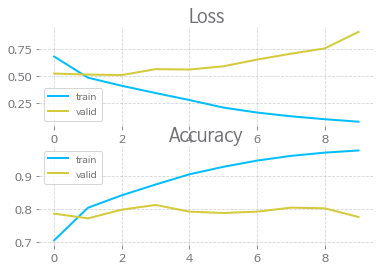

In [7]:
draw_history(history)

In [8]:
# Test
print("============================= Test =============================")
test_loss, test_acc = evaluate(model, device, criterion, test_loader)
print("test loss : {:.6f}".format(test_loss))
print("test acc : {:.3f}".format(test_acc))

============================= Test =============================
4it [00:00, 10.15it/s, loss=0.041722, acc=0.790]
test loss : 1.043060
test acc : 0.790


In [9]:
file_name = class_name+"_RoBERTa"
torch.save(model, f"models/{file_name}.pt")
with open(f"models/{file_name}_history.pickle", 'wb') as f:
    pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)

## Model 2
+ Mean Pooling

### Klue BERT-base

In [4]:
model_path = "klue/bert-base"

train_dataset = MyDataset(train_x, train_y, model_path=model_path)
valid_dataset = MyDataset(valid_x, valid_y, model_path=model_path)
test_dataset = MyDataset(test_x, test_y, model_path=model_path)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [5]:
class_name = "MyModel_2"
model = get_Model(class_name, model_path)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

device

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


'cuda'

In [6]:
# train
print("============================= Train =============================")
history = train(model, device, optimizer, criterion, 10, train_loader, valid_loader)

============================= Train =============================
147it [01:29,  1.64it/s, epoch=1/10, loss=0.009260, acc=0.740]
16it [00:01,  8.59it/s, loss=0.015065, acc=0.794]

147it [01:31,  1.61it/s, epoch=2/10, loss=0.006476, acc=0.826]
16it [00:01,  8.55it/s, loss=0.013906, acc=0.820]

147it [01:31,  1.61it/s, epoch=3/10, loss=0.004887, acc=0.877]
16it [00:01,  8.51it/s, loss=0.016348, acc=0.802]

147it [01:31,  1.61it/s, epoch=4/10, loss=0.003059, acc=0.930]
16it [00:01,  8.56it/s, loss=0.019302, acc=0.796]

147it [01:31,  1.61it/s, epoch=5/10, loss=0.001870, acc=0.957]
16it [00:01,  8.57it/s, loss=0.020821, acc=0.776]

147it [01:31,  1.61it/s, epoch=6/10, loss=0.001395, acc=0.971]
16it [00:01,  8.11it/s, loss=0.024872, acc=0.796]

147it [01:31,  1.61it/s, epoch=7/10, loss=0.000837, acc=0.982]
16it [00:01,  8.52it/s, loss=0.027298, acc=0.800]

147it [01:31,  1.61it/s, epoch=8/10, loss=0.000664, acc=0.984]
16it [00:01,  8.54it/s, loss=0.028824, acc=0.770]

147it [01:31,  1.61it/

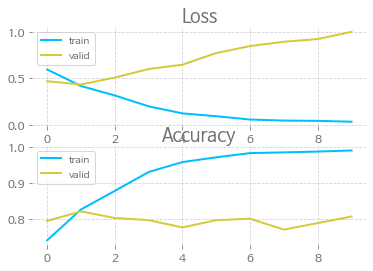

In [7]:
draw_history(history)

In [8]:
# Test
print("============================= Test =============================")
test_loss, test_acc = evaluate(model, device, criterion, test_loader)
print("test loss : {:.6f}".format(test_loss))
print("test acc : {:.3f}".format(test_acc))

============================= Test =============================
4it [00:00, 10.05it/s, loss=0.058455, acc=0.780]
test loss : 1.461363
test acc : 0.780


In [9]:
file_name = class_name+"_BERT"
torch.save(model, f"models/{file_name}.pt")
with open(f"models/{file_name}_history.pickle", 'wb') as f:
    pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)

### Klue RoBerta-base

In [4]:
model_path = "klue/roberta-base"

train_dataset = MyDataset(train_x, train_y, model_path=model_path)
valid_dataset = MyDataset(valid_x, valid_y, model_path=model_path)
test_dataset = MyDataset(test_x, test_y, model_path=model_path)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [5]:
class_name = "MyModel_2"
model = get_Model(class_name, model_path)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

device

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for

'cuda'

In [6]:
# train
print("============================= Train =============================")
history = train(model, device, optimizer, criterion, 10, train_loader, valid_loader)

============================= Train =============================
147it [01:30,  1.62it/s, epoch=1/10, loss=0.009962, acc=0.717]
16it [00:01,  8.47it/s, loss=0.015754, acc=0.802]

147it [01:31,  1.61it/s, epoch=2/10, loss=0.007262, acc=0.811]
16it [00:01,  8.47it/s, loss=0.015362, acc=0.808]

147it [01:31,  1.61it/s, epoch=3/10, loss=0.005991, acc=0.849]
16it [00:01,  8.58it/s, loss=0.016069, acc=0.836]

147it [01:31,  1.61it/s, epoch=4/10, loss=0.004981, acc=0.878]
16it [00:01,  8.32it/s, loss=0.017376, acc=0.800]

147it [01:31,  1.61it/s, epoch=5/10, loss=0.003803, acc=0.914]
16it [00:01,  8.63it/s, loss=0.018444, acc=0.802]

147it [01:31,  1.61it/s, epoch=6/10, loss=0.002850, acc=0.938]
16it [00:01,  8.55it/s, loss=0.020045, acc=0.808]

147it [01:31,  1.60it/s, epoch=7/10, loss=0.002148, acc=0.955]
16it [00:01,  8.49it/s, loss=0.021490, acc=0.818]

147it [01:31,  1.60it/s, epoch=8/10, loss=0.001858, acc=0.960]
16it [00:01,  8.59it/s, loss=0.022369, acc=0.804]

147it [01:31,  1.60it/

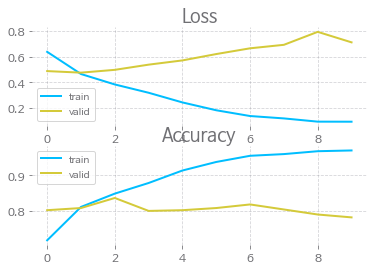

In [7]:
draw_history(history)

In [8]:
# Test
print("============================= Test =============================")
test_loss, test_acc = evaluate(model, device, criterion, test_loader)
print("test loss : {:.6f}".format(test_loss))
print("test acc : {:.3f}".format(test_acc))

============================= Test =============================
4it [00:00, 10.10it/s, loss=0.037029, acc=0.720]
test loss : 0.925730
test acc : 0.720


In [9]:
file_name = class_name+"_RoBERTa"
torch.save(model, f"models/{file_name}.pt")
with open(f"models/{file_name}_history.pickle", 'wb') as f:
    pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)

## Model 3
+ CLS Token
+ Contrastive Loss 적용

In [6]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                      (1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive
    
    
class My_Contrastive_Loss(nn.Module):
    def __init__(self, p=0.1, margin=2.0):
        super(My_Contrastive_Loss, self).__init__()
        
        self.p = p
        self.contrastive = ContrastiveLoss(margin)
        self.base = nn.CrossEntropyLoss()
        
    def forward(self, y_hat, output1, output2, target, c_y):
        return self.base(y_hat, target) + (self.p * self.contrastive(output1, output2, c_y))

In [7]:
def calc_acc(output, label):
    o_val, o_idx = torch.max(output, dim=-1)
    l_val, l_idx = torch.max(label, dim=-1)
    acc = (o_idx == l_idx).sum().item()
    return acc

def train_contrastive(model, device, optimizer, criterion, epochs, train_loader, valid_loader=None) -> dict:
    """
    :param model: your model
    :param device: your device(cuda or cpu)
    :param optimizer: your optimizer
    :param criterion: loss function
    :param epoch: train epochs
    :param train_loader: train dataset
    :param valid_loader: valid dataset
    :return: history dictionary that contains train_loss, train_acc, valid_loss, valid_acc as list
    """
    history = {
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': []
    }
    model.to(device)
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = train_acc = 0

        # in notebook
        # pabr = notebook.tqdm(enumerate(train_loader), file=sys.stdout)

        # in interpreter
        pbar = tqdm(enumerate(train_loader), file=sys.stdout)
        for batch_idx, (x, c, y) in pbar:
            x_input_ids, x_att_mask = x[0].to(device), x[1].to(device)
            c_input_ids, c_att_mask = c[0].to(device), c[1].to(device)
            target, c_y = y[0].to(device), y[1].to(device)

            optimizer.zero_grad()
            predict, output1, output2 = model(x_input_ids, x_att_mask, c_input_ids, c_att_mask)
            loss = criterion(predict, output1, output2, target, c_y)
            acc = calc_acc(predict, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += acc

            acc = train_acc / (batch_idx * train_loader.batch_size + len(target))
            loss = train_loss / (batch_idx * train_loader.batch_size + len(target))
            pbar.set_postfix(epoch=f'{epoch}/{epochs}', loss='{:.6f}, acc={:.3f}'.format(loss, acc))
        pbar.close()

        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_loader.dataset)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        if valid_loader is not None:
            valid_loss, valid_acc = evaluate_contrastive(model, device, criterion, valid_loader)

            history['valid_loss'].append(valid_loss)
            history['valid_acc'].append(valid_acc)
        print()

    return history


def evaluate_contrastive(model, device, criterion, data_loader):
    """
    :param model: your model
    :param device: your device(cuda or cpu)
    :param criterion: loss function
    :param data_loader: valid or test Datasets
    :return: (valid or test) loss and acc
    """
    model.eval()
    total_loss = total_acc = 0

    with torch.no_grad():
        # in notebook
        # pabr = notebook.tqdm(enumerate(valid_loader), file=sys.stdout)

        # in interpreter
        pbar = tqdm(enumerate(data_loader), file=sys.stdout)

        for batch_idx, (x, c, y) in pbar:
            x_input_ids, x_att_mask = x[0].to(device), x[1].to(device)
            c_input_ids, c_att_mask = c[0].to(device), c[1].to(device)
            target, c_y = y[0].to(device), y[1].to(device)

            predict, output1, output2 = model(x_input_ids, x_att_mask, c_input_ids, c_att_mask)
            loss = criterion(predict, output1, output2, target, c_y)
            acc = calc_acc(predict, target)

            total_loss += loss.item()
            total_acc += acc

            acc = total_acc / (batch_idx * data_loader.batch_size + len(target))
            loss = total_loss / (batch_idx * data_loader.batch_size + len(target))
            pbar.set_postfix(loss='{:.6f}, acc={:.3f}'.format(loss, acc))
        pbar.close()

    total_loss = total_loss / len(data_loader)
    total_acc = total_acc / len(data_loader.dataset)

    return total_loss, total_acc

### Klue BERT-base

In [6]:
model_path = "klue/bert-base"

train_dataset = MyDataset_Contrastive(train_x, train_y, model_path=model_path)
valid_dataset = MyDataset_Contrastive(valid_x, valid_y, model_path=model_path)
test_dataset = MyDataset_Contrastive(test_x, test_y, model_path=model_path)

train_loader = DataLoader(train_dataset, batch_size=32)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [7]:
class_name = "MyModel_3"
model = get_Model(class_name, model_path)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = My_Contrastive_Loss(p=0.1, margin=2)

device

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


'cuda'

In [8]:
# train
print("============================= Train =============================")
history = train_contrastive(model, device, optimizer, criterion, 10, train_loader, valid_loader)

============================= Train =============================
294it [03:11,  1.53it/s, epoch=1/10, loss=0.023857, acc=0.701]
16it [00:03,  4.04it/s, loss=0.019541, acc=0.790]

294it [03:12,  1.53it/s, epoch=2/10, loss=0.017027, acc=0.821]
16it [00:03,  4.23it/s, loss=0.020697, acc=0.778]

294it [03:12,  1.53it/s, epoch=3/10, loss=0.013688, acc=0.875]
16it [00:03,  4.17it/s, loss=0.020444, acc=0.802]

294it [03:12,  1.53it/s, epoch=4/10, loss=0.011530, acc=0.909]
16it [00:03,  4.12it/s, loss=0.022206, acc=0.778]

294it [03:13,  1.52it/s, epoch=5/10, loss=0.009413, acc=0.936]
16it [00:03,  4.16it/s, loss=0.023550, acc=0.794]

294it [03:13,  1.52it/s, epoch=6/10, loss=0.007735, acc=0.957]
16it [00:03,  4.17it/s, loss=0.026161, acc=0.804]

294it [03:13,  1.52it/s, epoch=7/10, loss=0.006843, acc=0.966]
16it [00:03,  4.19it/s, loss=0.029541, acc=0.766]

294it [03:14,  1.52it/s, epoch=8/10, loss=0.006212, acc=0.970]
16it [00:03,  4.18it/s, loss=0.033016, acc=0.778]

294it [03:14,  1.52it/

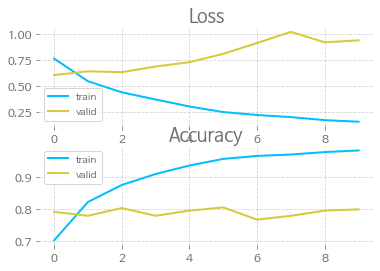

In [9]:
draw_history(history)

In [10]:
# Test
print("============================= Test =============================")
test_loss, test_acc = evaluate_contrastive(model, device, criterion, test_loader)
print("test loss : {:.6f}".format(test_loss))
print("test acc : {:.3f}".format(test_acc))

============================= Test =============================
4it [00:00,  4.90it/s, loss=0.039534, acc=0.850]
test loss : 0.988348
test acc : 0.850


In [11]:
file_name = class_name+"_BERT"
torch.save(model, f"models/{file_name}.pt")
with open(f"models/{file_name}_history.pickle", 'wb') as f:
    pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)

### Klue RoBerta-base

In [4]:
model_path = "klue/roberta-base"

train_dataset = MyDataset_Contrastive(train_x, train_y, model_path=model_path)
valid_dataset = MyDataset_Contrastive(valid_x, valid_y, model_path=model_path)
test_dataset = MyDataset_Contrastive(test_x, test_y, model_path=model_path)

train_loader = DataLoader(train_dataset, batch_size=32)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [10]:
class_name = "MyModel_3"
model = get_Model(class_name, model_path)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = My_Contrastive_Loss(p=0.1, margin=2)

device

'cuda'

In [11]:
# train
print("============================= Train =============================")
history = train_contrastive(model, device, optimizer, criterion, 10, train_loader, valid_loader)

============================= Train =============================
294it [03:11,  1.53it/s, epoch=1/10, loss=0.023062, acc=0.731]
16it [00:03,  4.26it/s, loss=0.021092, acc=0.774]

294it [03:13,  1.52it/s, epoch=2/10, loss=0.018137, acc=0.801]
16it [00:03,  4.14it/s, loss=0.020242, acc=0.788]

294it [03:13,  1.52it/s, epoch=3/10, loss=0.016334, acc=0.839]
16it [00:03,  4.26it/s, loss=0.020454, acc=0.782]

294it [03:12,  1.52it/s, epoch=4/10, loss=0.014215, acc=0.873]
16it [00:03,  4.22it/s, loss=0.020239, acc=0.790]

294it [03:13,  1.52it/s, epoch=5/10, loss=0.012363, acc=0.896]
16it [00:03,  4.14it/s, loss=0.021469, acc=0.800]

294it [03:13,  1.52it/s, epoch=6/10, loss=0.010882, acc=0.915]
16it [00:03,  4.24it/s, loss=0.024289, acc=0.800]

294it [03:13,  1.52it/s, epoch=7/10, loss=0.010154, acc=0.929]
16it [00:03,  4.22it/s, loss=0.024145, acc=0.812]

294it [03:13,  1.52it/s, epoch=8/10, loss=0.008934, acc=0.940]
16it [00:03,  4.25it/s, loss=0.028971, acc=0.762]

294it [03:12,  1.52it/

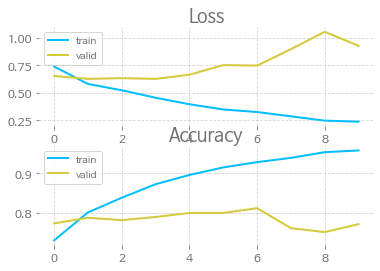

In [12]:
draw_history(history)

In [13]:
# Test
print("============================= Test =============================")
test_loss, test_acc = evaluate_contrastive(model, device, criterion, test_loader)
print("test loss : {:.6f}".format(test_loss))
print("test acc : {:.3f}".format(test_acc))

============================= Test =============================
4it [00:00,  4.94it/s, loss=0.041169, acc=0.770]
test loss : 1.029232
test acc : 0.770


In [14]:
file_name = class_name+"_RoBERTa"
torch.save(model, f"models/{file_name}.pt")
with open(f"models/{file_name}_history.pickle", 'wb') as f:
    pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)

## Model 4
+ Mean Pooling
+ Contrastive Loss 적용

In [4]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                      (1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive
    
    
class My_Contrastive_Loss(nn.Module):
    def __init__(self, p=0.1, margin=2.0):
        super(My_Contrastive_Loss, self).__init__()
        
        self.p = p
        self.contrastive = ContrastiveLoss(margin)
        self.base = nn.CrossEntropyLoss()
        
    def forward(self, y_hat, output1, output2, target, c_y):
        return self.base(y_hat, target) + (self.p * self.contrastive(output1, output2, c_y))

In [5]:
def calc_acc(output, label):
    o_val, o_idx = torch.max(output, dim=-1)
    l_val, l_idx = torch.max(label, dim=-1)
    acc = (o_idx == l_idx).sum().item()
    return acc

def train_contrastive(model, device, optimizer, criterion, epochs, train_loader, valid_loader=None) -> dict:
    """
    :param model: your model
    :param device: your device(cuda or cpu)
    :param optimizer: your optimizer
    :param criterion: loss function
    :param epoch: train epochs
    :param train_loader: train dataset
    :param valid_loader: valid dataset
    :return: history dictionary that contains train_loss, train_acc, valid_loss, valid_acc as list
    """
    history = {
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': []
    }
    model.to(device)
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = train_acc = 0

        # in notebook
        # pabr = notebook.tqdm(enumerate(train_loader), file=sys.stdout)

        # in interpreter
        pbar = tqdm(enumerate(train_loader), file=sys.stdout)
        for batch_idx, (x, c, y) in pbar:
            x_input_ids, x_att_mask = x[0].to(device), x[1].to(device)
            c_input_ids, c_att_mask = c[0].to(device), c[1].to(device)
            target, c_y = y[0].to(device), y[1].to(device)

            optimizer.zero_grad()
            predict, output1, output2 = model(x_input_ids, x_att_mask, c_input_ids, c_att_mask)
            loss = criterion(predict, output1, output2, target, c_y)
            acc = calc_acc(predict, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += acc

            acc = train_acc / (batch_idx * train_loader.batch_size + len(target))
            loss = train_loss / (batch_idx * train_loader.batch_size + len(target))
            pbar.set_postfix(epoch=f'{epoch}/{epochs}', loss='{:.6f}, acc={:.3f}'.format(loss, acc))
        pbar.close()

        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_loader.dataset)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        if valid_loader is not None:
            valid_loss, valid_acc = evaluate_contrastive(model, device, criterion, valid_loader)

            history['valid_loss'].append(valid_loss)
            history['valid_acc'].append(valid_acc)
        print()

    return history


def evaluate_contrastive(model, device, criterion, data_loader):
    """
    :param model: your model
    :param device: your device(cuda or cpu)
    :param criterion: loss function
    :param data_loader: valid or test Datasets
    :return: (valid or test) loss and acc
    """
    model.eval()
    total_loss = total_acc = 0

    with torch.no_grad():
        # in notebook
        # pabr = notebook.tqdm(enumerate(valid_loader), file=sys.stdout)

        # in interpreter
        pbar = tqdm(enumerate(data_loader), file=sys.stdout)

        for batch_idx, (x, c, y) in pbar:
            x_input_ids, x_att_mask = x[0].to(device), x[1].to(device)
            c_input_ids, c_att_mask = c[0].to(device), c[1].to(device)
            target, c_y = y[0].to(device), y[1].to(device)

            predict, output1, output2 = model(x_input_ids, x_att_mask, c_input_ids, c_att_mask)
            loss = criterion(predict, output1, output2, target, c_y)
            acc = calc_acc(predict, target)

            total_loss += loss.item()
            total_acc += acc

            acc = total_acc / (batch_idx * data_loader.batch_size + len(target))
            loss = total_loss / (batch_idx * data_loader.batch_size + len(target))
            pbar.set_postfix(loss='{:.6f}, acc={:.3f}'.format(loss, acc))
        pbar.close()

    total_loss = total_loss / len(data_loader)
    total_acc = total_acc / len(data_loader.dataset)

    return total_loss, total_acc

### Klue BERT-base

In [6]:
model_path = "klue/bert-base"

train_dataset = MyDataset_Contrastive(train_x, train_y, model_path=model_path)
valid_dataset = MyDataset_Contrastive(valid_x, valid_y, model_path=model_path)
test_dataset = MyDataset_Contrastive(test_x, test_y, model_path=model_path)

train_loader = DataLoader(train_dataset, batch_size=32)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [7]:
class_name = "MyModel_4"
model = get_Model(class_name, model_path)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = My_Contrastive_Loss(p=0.1, margin=2)

device

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


'cuda'

In [8]:
# train
print("============================= Train =============================")
history = train_contrastive(model, device, optimizer, criterion, 10, train_loader, valid_loader)

============================= Train =============================
294it [03:13,  1.52it/s, epoch=1/10, loss=0.024195, acc=0.693]
16it [00:03,  4.17it/s, loss=0.019802, acc=0.780]

294it [03:13,  1.52it/s, epoch=2/10, loss=0.017003, acc=0.818]
16it [00:03,  4.17it/s, loss=0.019347, acc=0.786]

294it [03:13,  1.52it/s, epoch=3/10, loss=0.013705, acc=0.873]
16it [00:03,  4.24it/s, loss=0.021764, acc=0.788]

294it [03:12,  1.52it/s, epoch=4/10, loss=0.011168, acc=0.908]
16it [00:03,  4.17it/s, loss=0.023269, acc=0.778]

294it [03:12,  1.53it/s, epoch=5/10, loss=0.008719, acc=0.942]
16it [00:03,  4.20it/s, loss=0.026355, acc=0.792]

294it [03:11,  1.53it/s, epoch=6/10, loss=0.007583, acc=0.954]
16it [00:03,  4.21it/s, loss=0.026833, acc=0.808]

294it [03:12,  1.53it/s, epoch=7/10, loss=0.005980, acc=0.971]
16it [00:03,  4.12it/s, loss=0.028825, acc=0.792]

294it [03:13,  1.52it/s, epoch=8/10, loss=0.005233, acc=0.979]
16it [00:03,  4.13it/s, loss=0.034288, acc=0.784]

294it [03:13,  1.52it/

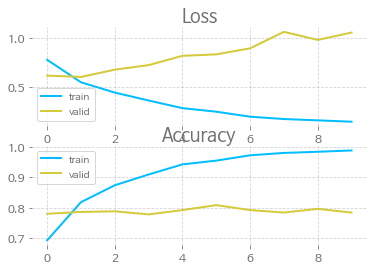

In [9]:
draw_history(history)

In [10]:
# Test
print("============================= Test =============================")
test_loss, test_acc = evaluate_contrastive(model, device, criterion, test_loader)
print("test loss : {:.6f}".format(test_loss))
print("test acc : {:.3f}".format(test_acc))

============================= Test =============================
4it [00:00,  5.12it/s, loss=0.053007, acc=0.780]
test loss : 1.325180
test acc : 0.780


In [11]:
file_name = class_name+"_BERT"
torch.save(model, f"models/{file_name}.pt")
with open(f"models/{file_name}_history.pickle", 'wb') as f:
    pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)

### Klue RoBerta-base

In [6]:
model_path = "klue/roberta-base"

train_dataset = MyDataset_Contrastive(train_x, train_y, model_path=model_path)
valid_dataset = MyDataset_Contrastive(valid_x, valid_y, model_path=model_path)
test_dataset = MyDataset_Contrastive(test_x, test_y, model_path=model_path)

train_loader = DataLoader(train_dataset, batch_size=32)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [7]:
class_name = "MyModel_4"
model = get_Model(class_name, model_path)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = My_Contrastive_Loss(p=0.1, margin=2)

device

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

'cuda'

In [8]:
# train
print("============================= Train =============================")
history = train_contrastive(model, device, optimizer, criterion, 10, train_loader, valid_loader)

============================= Train =============================
294it [03:11,  1.54it/s, epoch=1/10, loss=0.022256, acc=0.739]
16it [00:03,  4.13it/s, loss=0.021060, acc=0.776]

294it [03:13,  1.52it/s, epoch=2/10, loss=0.017735, acc=0.812]
16it [00:03,  4.27it/s, loss=0.019322, acc=0.796]

294it [03:13,  1.52it/s, epoch=3/10, loss=0.015283, acc=0.854]
16it [00:03,  4.23it/s, loss=0.021642, acc=0.762]

294it [03:14,  1.51it/s, epoch=4/10, loss=0.013371, acc=0.886]
16it [00:03,  4.15it/s, loss=0.022318, acc=0.782]

294it [03:14,  1.51it/s, epoch=5/10, loss=0.011594, acc=0.908]
16it [00:03,  4.18it/s, loss=0.023889, acc=0.786]

294it [03:14,  1.51it/s, epoch=6/10, loss=0.010474, acc=0.922]
16it [00:03,  4.17it/s, loss=0.023841, acc=0.772]

294it [03:14,  1.51it/s, epoch=7/10, loss=0.008894, acc=0.939]
16it [00:03,  4.24it/s, loss=0.023346, acc=0.808]

294it [03:14,  1.51it/s, epoch=8/10, loss=0.008207, acc=0.948]
16it [00:03,  4.24it/s, loss=0.023284, acc=0.812]

294it [03:14,  1.51it/

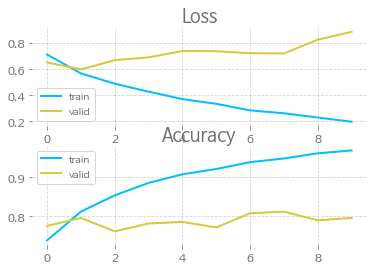

In [9]:
draw_history(history)

In [10]:
# Test
print("============================= Test =============================")
test_loss, test_acc = evaluate_contrastive(model, device, criterion, test_loader)
print("test loss : {:.6f}".format(test_loss))
print("test acc : {:.3f}".format(test_acc))

============================= Test =============================
4it [00:00,  5.17it/s, loss=0.036244, acc=0.770]
test loss : 0.906104
test acc : 0.770


In [11]:
file_name = class_name+"_RoBERTa"
torch.save(model, f"models/{file_name}.pt")
with open(f"models/{file_name}_history.pickle", 'wb') as f:
    pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)

## Model 5
+ CLS Token
+ Triplet Loss 적용

In [4]:
class TripletLoss(nn.Module):
    def __init__(self, margin = 1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1-x2).pow(2).sum(1) 
    
    def forward(self,  anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor):
        
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

class My_Triplet_Loss(nn.Module):
    def __init__(self, p=0.1, margin=2.0):
        super(My_Triplet_Loss, self).__init__()
        
        self.p = p
        self.triplet = TripletLoss(margin=1.0)
        self.CE = nn.CrossEntropyLoss()
        
    def forward(self, predict, x_embed, p_embed, n_embed, target):
        triplet = self.triplet(x_embed, p_embed, n_embed)
        ce = self.CE(predict, target)
        return ce + (self.p * triplet)

In [5]:
def calc_acc(output, label):
    o_val, o_idx = torch.max(output, dim=-1)
    l_val, l_idx = torch.max(label, dim=-1)
    acc = (o_idx == l_idx).sum().item()
    return acc

def train_triplet(model, device, optimizer, criterion, epochs, train_loader, valid_loader=None) -> dict:
    """
    :param model: your model
    :param device: your device(cuda or cpu)
    :param optimizer: your optimizer
    :param criterion: loss function
    :param epoch: train epochs
    :param train_loader: train dataset
    :param valid_loader: valid dataset
    :return: history dictionary that contains train_loss, train_acc, valid_loss, valid_acc as list
    """
    history = {
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': []
    }
    model.to(device)
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = train_acc = 0

        # in notebook
        # pabr = notebook.tqdm(enumerate(train_loader), file=sys.stdout)

        # in interpreter
        pbar = tqdm(enumerate(train_loader), file=sys.stdout)
        for batch_idx, (x, p, n, target) in pbar:
            anchor_inputs, anchor_atts = x[0].to(device), x[1].to(device)
            p_inputs, p_atts = p[0].to(device), p[1].to(device)
            n_inputs, n_atts = n[0].to(device), n[1].to(device)
            target = target.to(device)
            
            optimizer.zero_grad()
            predict, anchor, pos, neg = model(anchor_inputs, anchor_atts,
                                             p_inputs, p_atts, n_inputs, n_atts)
            loss = criterion(predict, anchor, pos, neg, target)
            acc = calc_acc(predict, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += acc

            acc = train_acc / (batch_idx * train_loader.batch_size + len(target))
            loss = train_loss / (batch_idx * train_loader.batch_size + len(target))
            pbar.set_postfix(epoch=f'{epoch}/{epochs}', loss='{:.6f}, acc={:.3f}'.format(loss, acc))
        pbar.close()

        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_loader.dataset)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        if valid_loader is not None:
            valid_loss, valid_acc = evaluate_triplet(model, device, criterion, valid_loader)

            history['valid_loss'].append(valid_loss)
            history['valid_acc'].append(valid_acc)
        print()

    return history


def evaluate_triplet(model, device, criterion, data_loader):
    """
    :param model: your model
    :param device: your device(cuda or cpu)
    :param criterion: loss function
    :param data_loader: valid or test Datasets
    :return: (valid or test) loss and acc
    """
    model.eval()
    total_loss = total_acc = 0

    with torch.no_grad():
        # in notebook
        # pabr = notebook.tqdm(enumerate(valid_loader), file=sys.stdout)

        # in interpreter
        pbar = tqdm(enumerate(data_loader), file=sys.stdout)

        for batch_idx, (x, p, n, target) in pbar:
            anchor_inputs, anchor_atts = x[0].to(device), x[1].to(device)
            p_inputs, p_atts = p[0].to(device), p[1].to(device)
            n_inputs, n_atts = n[0].to(device), n[1].to(device)
            target = target.to(device)

            predict, anchor, pos, neg = model(anchor_inputs, anchor_atts,
                                             p_inputs, p_atts, n_inputs, n_atts)
            loss = criterion(predict, anchor, pos, neg, target)
            acc = calc_acc(predict, target)

            total_loss += loss.item()
            total_acc += acc

            acc = total_acc / (batch_idx * data_loader.batch_size + len(target))
            loss = total_loss / (batch_idx * data_loader.batch_size + len(target))
            pbar.set_postfix(loss='{:.6f}, acc={:.3f}'.format(loss, acc))
        pbar.close()

    total_loss = total_loss / len(data_loader)
    total_acc = total_acc / len(data_loader.dataset)

    return total_loss, total_acc

### Klue BERT-base

In [6]:
model_path = "klue/bert-base"

train_dataset = MyDataset_Triplet(train_x, train_y, model_path=model_path)
valid_dataset = MyDataset_Triplet(valid_x, valid_y, model_path=model_path)
test_dataset = MyDataset_Triplet(test_x, test_y, model_path=model_path)

train_loader = DataLoader(train_dataset, batch_size=32)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [7]:
class_name = "MyModel_5"
model = get_Model(class_name, model_path)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = My_Triplet_Loss(p=0.1, margin=2)

device

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


'cuda'

In [8]:
# train
print("============================= Train =============================")
history = train_triplet(model, device, optimizer, criterion, 10, train_loader, valid_loader)

============================= Train =============================
294it [04:52,  1.00it/s, epoch=1/10, loss=0.021876, acc=0.723]
16it [00:05,  2.82it/s, loss=0.017896, acc=0.782]

294it [04:55,  1.01s/it, epoch=2/10, loss=0.015164, acc=0.826]
16it [00:05,  2.81it/s, loss=0.017106, acc=0.810]

294it [04:55,  1.00s/it, epoch=3/10, loss=0.011435, acc=0.880]
16it [00:05,  2.81it/s, loss=0.019729, acc=0.804]

294it [04:56,  1.01s/it, epoch=4/10, loss=0.008321, acc=0.919]
16it [00:05,  2.79it/s, loss=0.022338, acc=0.796]

294it [04:56,  1.01s/it, epoch=5/10, loss=0.005972, acc=0.944]
16it [00:05,  2.80it/s, loss=0.024982, acc=0.794]

294it [04:56,  1.01s/it, epoch=6/10, loss=0.004648, acc=0.958]
16it [00:05,  2.81it/s, loss=0.026375, acc=0.780]

294it [04:56,  1.01s/it, epoch=7/10, loss=0.002966, acc=0.976]
16it [00:05,  2.77it/s, loss=0.032201, acc=0.754]

294it [04:55,  1.01s/it, epoch=8/10, loss=0.002500, acc=0.978]
16it [00:05,  2.78it/s, loss=0.029028, acc=0.794]

294it [04:54,  1.00s/i

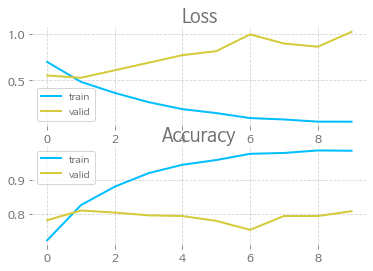

In [9]:
draw_history(history)

In [10]:
# Test
print("============================= Test =============================")
test_loss, test_acc = evaluate_triplet(model, device, criterion, test_loader)
print("test loss : {:.6f}".format(test_loss))
print("test acc : {:.3f}".format(test_acc))

============================= Test =============================
4it [00:01,  3.45it/s, loss=0.043224, acc=0.810]
test loss : 1.080606
test acc : 0.810


In [11]:
file_name = class_name+"_BERT"
torch.save(model, f"models/{file_name}.pt")
with open(f"models/{file_name}_history.pickle", 'wb') as f:
    pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)

### Klue RoBerta-base

In [6]:
model_path = "klue/roberta-base"

train_dataset = MyDataset_Triplet(train_x, train_y, model_path=model_path)
valid_dataset = MyDataset_Triplet(valid_x, valid_y, model_path=model_path)
test_dataset = MyDataset_Triplet(test_x, test_y, model_path=model_path)

train_loader = DataLoader(train_dataset, batch_size=32)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [7]:
class_name = "MyModel_5"
model = get_Model(class_name, model_path)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = My_Triplet_Loss(p=0.1, margin=2)

device

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for

'cuda'

In [8]:
# train
print("============================= Train =============================")
history = train_triplet(model, device, optimizer, criterion, 10, train_loader, valid_loader)

============================= Train =============================
294it [04:54,  1.00s/it, epoch=1/10, loss=0.022813, acc=0.715]
16it [00:05,  2.84it/s, loss=0.018997, acc=0.772]

294it [04:55,  1.01s/it, epoch=2/10, loss=0.016521, acc=0.811]
16it [00:05,  2.86it/s, loss=0.017110, acc=0.804]

294it [04:54,  1.00s/it, epoch=3/10, loss=0.014000, acc=0.847]
16it [00:05,  2.86it/s, loss=0.018080, acc=0.802]

294it [04:54,  1.00s/it, epoch=4/10, loss=0.011349, acc=0.884]
16it [00:05,  2.84it/s, loss=0.020450, acc=0.784]

294it [04:54,  1.00s/it, epoch=5/10, loss=0.009777, acc=0.904]
16it [00:05,  2.86it/s, loss=0.020710, acc=0.776]

294it [04:54,  1.00s/it, epoch=6/10, loss=0.008318, acc=0.919]
16it [00:05,  2.86it/s, loss=0.018744, acc=0.828]

294it [04:55,  1.00s/it, epoch=7/10, loss=0.006226, acc=0.943]
16it [00:05,  2.82it/s, loss=0.023942, acc=0.772]

294it [04:55,  1.00s/it, epoch=8/10, loss=0.005583, acc=0.950]
16it [00:05,  2.86it/s, loss=0.030279, acc=0.774]

294it [04:54,  1.00s/i

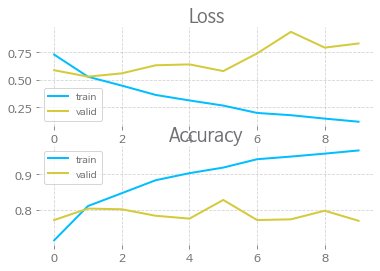

In [9]:
draw_history(history)

In [10]:
# Test
print("============================= Test =============================")
test_loss, test_acc = evaluate_triplet(model, device, criterion, test_loader)
print("test loss : {:.6f}".format(test_loss))
print("test acc : {:.3f}".format(test_acc))

============================= Test =============================
4it [00:01,  3.48it/s, loss=0.040096, acc=0.750]
test loss : 1.002398
test acc : 0.750


In [11]:
file_name = class_name+"_RoBERTa"
torch.save(model, f"models/{file_name}.pt")
with open(f"models/{file_name}_history.pickle", 'wb') as f:
    pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)

## Model 6
+ Mean Pooling
+ Triplet Loss 적용

In [4]:
class TripletLoss(nn.Module):
    def __init__(self, margin = 1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1-x2).pow(2).sum(1) 
    
    def forward(self,  anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor):
        
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

class My_Triplet_Loss(nn.Module):
    def __init__(self, p=0.1, margin=2.0):
        super(My_Triplet_Loss, self).__init__()
        
        self.p = p
        self.triplet = TripletLoss(margin=1.0)
        self.CE = nn.CrossEntropyLoss()
        
    def forward(self, predict, x_embed, p_embed, n_embed, target):
        triplet = self.triplet(x_embed, p_embed, n_embed)
        ce = self.CE(predict, target)
        return ce + (self.p * triplet)

In [5]:
def calc_acc(output, label):
    o_val, o_idx = torch.max(output, dim=-1)
    l_val, l_idx = torch.max(label, dim=-1)
    acc = (o_idx == l_idx).sum().item()
    return acc

def train_triplet(model, device, optimizer, criterion, epochs, train_loader, valid_loader=None) -> dict:
    """
    :param model: your model
    :param device: your device(cuda or cpu)
    :param optimizer: your optimizer
    :param criterion: loss function
    :param epoch: train epochs
    :param train_loader: train dataset
    :param valid_loader: valid dataset
    :return: history dictionary that contains train_loss, train_acc, valid_loss, valid_acc as list
    """
    history = {
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': []
    }
    model.to(device)
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = train_acc = 0

        # in notebook
        # pabr = notebook.tqdm(enumerate(train_loader), file=sys.stdout)

        # in interpreter
        pbar = tqdm(enumerate(train_loader), file=sys.stdout)
        for batch_idx, (x, p, n, target) in pbar:
            anchor_inputs, anchor_atts = x[0].to(device), x[1].to(device)
            p_inputs, p_atts = p[0].to(device), p[1].to(device)
            n_inputs, n_atts = n[0].to(device), n[1].to(device)
            target = target.to(device)
            
            optimizer.zero_grad()
            predict, anchor, pos, neg = model(anchor_inputs, anchor_atts,
                                             p_inputs, p_atts, n_inputs, n_atts)
            loss = criterion(predict, anchor, pos, neg, target)
            acc = calc_acc(predict, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += acc

            acc = train_acc / (batch_idx * train_loader.batch_size + len(target))
            loss = train_loss / (batch_idx * train_loader.batch_size + len(target))
            pbar.set_postfix(epoch=f'{epoch}/{epochs}', loss='{:.6f}, acc={:.3f}'.format(loss, acc))
        pbar.close()

        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_loader.dataset)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        if valid_loader is not None:
            valid_loss, valid_acc = evaluate_triplet(model, device, criterion, valid_loader)

            history['valid_loss'].append(valid_loss)
            history['valid_acc'].append(valid_acc)
        print()

    return history


def evaluate_triplet(model, device, criterion, data_loader):
    """
    :param model: your model
    :param device: your device(cuda or cpu)
    :param criterion: loss function
    :param data_loader: valid or test Datasets
    :return: (valid or test) loss and acc
    """
    model.eval()
    total_loss = total_acc = 0

    with torch.no_grad():
        # in notebook
        # pabr = notebook.tqdm(enumerate(valid_loader), file=sys.stdout)

        # in interpreter
        pbar = tqdm(enumerate(data_loader), file=sys.stdout)

        for batch_idx, (x, p, n, target) in pbar:
            anchor_inputs, anchor_atts = x[0].to(device), x[1].to(device)
            p_inputs, p_atts = p[0].to(device), p[1].to(device)
            n_inputs, n_atts = n[0].to(device), n[1].to(device)
            target = target.to(device)

            predict, anchor, pos, neg = model(anchor_inputs, anchor_atts,
                                             p_inputs, p_atts, n_inputs, n_atts)
            loss = criterion(predict, anchor, pos, neg, target)
            acc = calc_acc(predict, target)

            total_loss += loss.item()
            total_acc += acc

            acc = total_acc / (batch_idx * data_loader.batch_size + len(target))
            loss = total_loss / (batch_idx * data_loader.batch_size + len(target))
            pbar.set_postfix(loss='{:.6f}, acc={:.3f}'.format(loss, acc))
        pbar.close()

    total_loss = total_loss / len(data_loader)
    total_acc = total_acc / len(data_loader.dataset)

    return total_loss, total_acc

### Klue BERT-base

In [6]:
model_path = "klue/bert-base"

train_dataset = MyDataset_Triplet(train_x, train_y, model_path=model_path)
valid_dataset = MyDataset_Triplet(valid_x, valid_y, model_path=model_path)
test_dataset = MyDataset_Triplet(test_x, test_y, model_path=model_path)

train_loader = DataLoader(train_dataset, batch_size=32)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [7]:
class_name = "MyModel_6"
model = get_Model(class_name, model_path)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = My_Triplet_Loss(p=0.1, margin=2)

device

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


'cuda'

In [8]:
# train
print("============================= Train =============================")
history = train_triplet(model, device, optimizer, criterion, 10, train_loader, valid_loader)

============================= Train =============================
294it [04:57,  1.01s/it, epoch=1/10, loss=0.021607, acc=0.727]
16it [00:06,  2.66it/s, loss=0.018853, acc=0.780]

294it [05:01,  1.03s/it, epoch=2/10, loss=0.014444, acc=0.832]
16it [00:05,  2.75it/s, loss=0.018142, acc=0.776]

294it [05:04,  1.03s/it, epoch=3/10, loss=0.010067, acc=0.891]
16it [00:05,  2.72it/s, loss=0.021393, acc=0.772]

294it [05:03,  1.03s/it, epoch=4/10, loss=0.006540, acc=0.937]
16it [00:05,  2.72it/s, loss=0.025344, acc=0.804]

294it [05:03,  1.03s/it, epoch=5/10, loss=0.005045, acc=0.951]
16it [00:05,  2.76it/s, loss=0.027507, acc=0.749]

294it [05:00,  1.02s/it, epoch=6/10, loss=0.003865, acc=0.964]
16it [00:05,  2.71it/s, loss=0.029126, acc=0.784]

294it [05:01,  1.03s/it, epoch=7/10, loss=0.002575, acc=0.975]
16it [00:05,  2.74it/s, loss=0.030636, acc=0.794]

294it [04:59,  1.02s/it, epoch=8/10, loss=0.001669, acc=0.985]
16it [00:05,  2.76it/s, loss=0.032602, acc=0.796]

294it [04:58,  1.01s/i

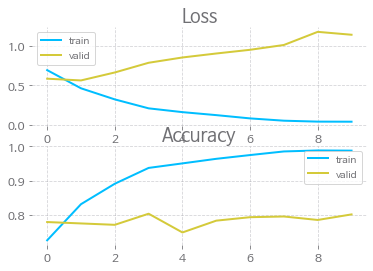

In [9]:
draw_history(history)

In [10]:
# Test
print("============================= Test =============================")
test_loss, test_acc = evaluate_triplet(model, device, criterion, test_loader)
print("test loss : {:.6f}".format(test_loss))
print("test acc : {:.3f}".format(test_acc))

============================= Test =============================
4it [00:01,  3.31it/s, loss=0.063592, acc=0.770]
test loss : 1.589790
test acc : 0.770


In [11]:
file_name = class_name+"_BERT"
torch.save(model, f"models/{file_name}.pt")
with open(f"models/{file_name}_history.pickle", 'wb') as f:
    pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)

### Klue RoBerta-base

In [6]:
model_path = "klue/roberta-base"

train_dataset = MyDataset_Triplet(train_x, train_y, model_path=model_path)
valid_dataset = MyDataset_Triplet(valid_x, valid_y, model_path=model_path)
test_dataset = MyDataset_Triplet(test_x, test_y, model_path=model_path)

train_loader = DataLoader(train_dataset, batch_size=32)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [7]:
class_name = "MyModel_6"
model = get_Model(class_name, model_path)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = My_Triplet_Loss(p=0.1, margin=2)

device

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for

'cuda'

In [8]:
# train
print("============================= Train =============================")
history = train_triplet(model, device, optimizer, criterion, 10, train_loader, valid_loader)

============================= Train =============================
294it [04:54,  1.00s/it, epoch=1/10, loss=0.021492, acc=0.731]
16it [00:05,  2.78it/s, loss=0.018707, acc=0.784]

294it [04:55,  1.01s/it, epoch=2/10, loss=0.016278, acc=0.811]
16it [00:05,  2.78it/s, loss=0.017452, acc=0.798]

294it [04:56,  1.01s/it, epoch=3/10, loss=0.013596, acc=0.852]
16it [00:05,  2.77it/s, loss=0.018439, acc=0.792]

294it [04:58,  1.02s/it, epoch=4/10, loss=0.010752, acc=0.891]
16it [00:05,  2.81it/s, loss=0.017407, acc=0.814]

294it [04:57,  1.01s/it, epoch=5/10, loss=0.008374, acc=0.920]
16it [00:05,  2.79it/s, loss=0.018631, acc=0.802]

294it [04:58,  1.01s/it, epoch=6/10, loss=0.007025, acc=0.934]
16it [00:05,  2.80it/s, loss=0.023216, acc=0.790]

294it [04:58,  1.01s/it, epoch=7/10, loss=0.006468, acc=0.937]
16it [00:05,  2.78it/s, loss=0.021582, acc=0.798]

294it [04:57,  1.01s/it, epoch=8/10, loss=0.004856, acc=0.956]
16it [00:05,  2.85it/s, loss=0.024960, acc=0.788]

294it [04:55,  1.01s/i

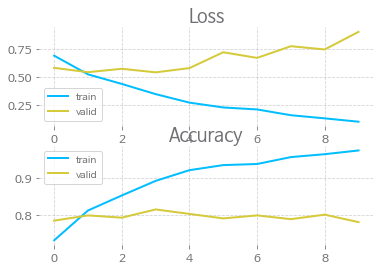

In [9]:
draw_history(history)

In [10]:
# Test
print("============================= Test =============================")
test_loss, test_acc = evaluate_triplet(model, device, criterion, test_loader)
print("test loss : {:.6f}".format(test_loss))
print("test acc : {:.3f}".format(test_acc))

============================= Test =============================
4it [00:01,  3.45it/s, loss=0.044313, acc=0.760]
test loss : 1.107824
test acc : 0.760


In [11]:
file_name = class_name+"_RoBERTa"
torch.save(model, f"models/{file_name}.pt")
with open(f"models/{file_name}_history.pickle", 'wb') as f:
    pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)